
# 패키지 설치 및 임포트

In [ ]:
import pandas as pd
import numpy as np
import tensorflow.keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
import cv2
import scipy
from scipy.spatial.distance import cosine
from google.colab.patches import cv2_imshow
from PIL import Image
import os
from tqdm import tqdm
import glob

In [ ]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

     |████████████████████████████████| 105 kB 8.8 MB/s eta 0:00:01
     |████████████████████████████████| 89.7 MB 18 kB/s 


In [ ]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ### 
from torchvision import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset
import torchvision

# 모델 로드 및 설정

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

device = torch.device("cuda")

In [ ]:
# network = torch.load('/content/drive/MyDrive/Colab Notebooks/TripletLoss_0200.pt').to(device)
network = torch.load('/content/drive/MyDrive/Colab Notebooks/k_fashion_0069.pt').to(device)
network.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def get_feature_vector(img):
  img = Image.fromarray(img)
  img = transform(img)
  img = img.unsqueeze(0).to(device)
  output = network(img).to('cpu')
  feature_vector = output.detach().numpy()[0]
  return feature_vector

# Annoy

In [ ]:
# https://github.com/spotify/annoy

In [ ]:
!pip install annoy

     |████████████████████████████████| 646 kB 9.8 MB/s eta 0:00:01
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391676 sha256=c8fc72639971534343cc03bf51563f6b7fc1c44181e0cd3a280f4aa7bba50312
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [ ]:
from annoy import AnnoyIndex
import pickle

In [ ]:
# 인스타용
ins_dir = '/content/drive/MyDrive/playdata_project/data/image/insta_cropped_image'
f = 1000
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
# file_index = {k:v for k, v in enumerate(os.listdir(cropped_dir)[:1000])}
insta_index = {k:v for k, v in enumerate(os.listdir(ins_dir))}
with open('/content/drive/MyDrive/playdata_project/data/pickle_model/insta_index.pickle', 'wb') as f:
    pickle.dump(insta_index, f, pickle.HIGHEST_PROTOCOL) # dump : serialize(직렬화)

for no, fn in tqdm(insta_index.items()):

  img = cv2.imread('{}/{}'.format(ins_dir,fn))

  v = get_feature_vector(img)
  # print(v.shape)
  # break
  t.add_item(no, v)

t.build(10) # 10 trees
t.save('/content/drive/MyDrive/playdata_project/data/pickle_model/insta_search.ann') # insta 검색용

  0%|          | 0/2108 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 2108/2108 [07:37<00:00,  4.61it/s]


True

In [ ]:
with open('/content/drive/MyDrive/playdata_project/data/pickle_model/insta_index.pickle', 'rb') as f :
  insta_index = pickle.load(f)

insta_search = AnnoyIndex(1000, 'angular')
insta_search.load('/content/drive/MyDrive/playdata_project/data/pickle_model/insta_search.ann') # super fast, will just mmap the file

True

In [ ]:
# 무신사용
mu_dir = '/content/drive/MyDrive/playdata_project/data/image/mall_image'
f = 1000
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
# file_index = {k:v for k, v in enumerate(os.listdir(cropped_dir)[:1000])}
mu_index = {k:v for k, v in enumerate(os.listdir(mu_dir))}
with open('/content/drive/MyDrive/playdata_project/data/pickle_model/musinsa_index.pickle', 'wb') as f:
    pickle.dump(mu_index, f, pickle.HIGHEST_PROTOCOL)

for no, fn in tqdm(mu_index.items()):
  img = cv2.imread('{}/{}'.format(mu_dir,fn))
  v = get_feature_vector(img)
  # print(v.shape)
  # break
  t.add_item(no, v)

t.build(10) # 10 trees
t.save('/content/drive/MyDrive/playdata_project/data/pickle_model/musinsa_search.ann') # musinsz 검색용

  0%|          | 229/89930 [01:04<7:50:12,  3.18it/s]

In [ ]:
with open('/content/drive/MyDrive/playdata_project/data/pickle_model/musinsa_index.pickle', 'rb') as f :
  mu_index = pickle.load(f)

mu_search = AnnoyIndex(1000, 'angular')
mu_search.load('/content/drive/MyDrive/playdata_project/data/pickle_model/musinsa_search.ann') # super fast, will just mmap the file

True

In [ ]:
# img = cv2.imread("/content/drive/MyDrive/playdata_project/data/image/insta_cropped_image/1_175.jpg")
# q = get_feature_vector(img)
# result = insta_search.get_nns_by_vector(q, 5, include_distances=True)
# # result
# result = list(zip(result[0], result[1]))
# # print(result)
# result = [(insta_index[no], score) for no, score in result]
# print(result)


# cv2_imshow(cv2.resize(img, (300,400)))

# for fn, score in result:
#   img = cv2.imread('{}/{}'.format(cropped_dir, fn))
#   cv2_imshow(cv2.resize(img, (300,400)))
#   print('{} : {}'.format(fn, score))

[('남자옷_image36_p0_b0_c7.jpg', 1.1800562143325806), ('남자옷_image135_p0_b1_c6.jpg', 1.1838802099227905), ('남성패션_image464_p0_b0_c7.jpg', 1.1873677968978882), ('남자옷_image676_p0_b0_c6.jpg', 1.190866470336914), ('남자옷_image303_p0_b1_c7.jpg', 1.1948537826538086)]


In [ ]:
# 무신사용 검색기
def match_mu(fn) :
  mu_dir = '/content/drive/MyDrive/playdata_project/data/image/mall_image'
  img = cv2.imread(fn)
  q = get_feature_vector(img)

  result = mu_search.get_nns_by_vector(q, 5, include_distances=True)
  result = list(zip(result[0], result[1]))
  result = [('{}/{}'.format(mu_dir,mu_index[no]), score) for no, score in result]
  return result


In [ ]:
# 인스타용 검색기
def match_insta(fn) :
  insta_dir = '/content/drive/MyDrive/playdata_project/data/image/insta_cropped_image'
  img = cv2.imread(fn)
  q = get_feature_vector(img)

  result = insta_search.get_nns_by_vector(q, 5, include_distances=True)
  result = list(zip(result[0], result[1]))
  result = [('{}/{}'.format(insta_dir,insta_index[no]), score) for no, score in result]
  return result

In [ ]:
def display(result) :
  for fn, score in result:
    img = cv2.imread(fn)
    cv2_imshow(cv2.resize(img, (150,200)))
    print('{} : {}'.format(fn, score))

In [ ]:
match_mu('/content/drive/MyDrive/img00/cropped_img2/남자코디_image107_b0_c0.jpg')

[('/content/drive/MyDrive/img00/img_mu/1_347.jpg', 1.2883601188659668),
 ('/content/drive/MyDrive/img00/img_mu/1_127.jpg', 1.2944512367248535),
 ('/content/drive/MyDrive/img00/img_mu/1_368.jpg', 1.2945793867111206),
 ('/content/drive/MyDrive/img00/img_mu/1_74.jpg', 1.3014627695083618),
 ('/content/drive/MyDrive/img00/img_mu/1_23.jpg', 1.3019728660583496)]

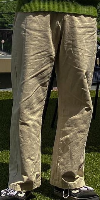

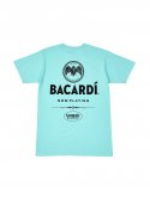

/content/drive/MyDrive/img00/img_mu/1_345.jpg : 1.257676362991333


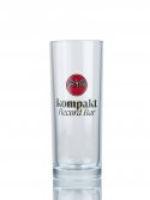

/content/drive/MyDrive/img00/img_mu/1_347.jpg : 1.2740426063537598


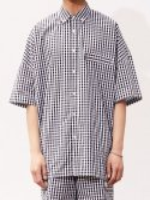

/content/drive/MyDrive/img00/img_mu/1_23.jpg : 1.2749295234680176


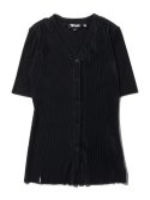

/content/drive/MyDrive/img00/img_mu/1_55.jpg : 1.2934348583221436


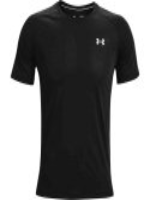

/content/drive/MyDrive/img00/img_mu/1_73.jpg : 1.2961145639419556


In [ ]:
query = '/content/drive/MyDrive/img00/cropped_img2/남자코디_image105_b0_c7.jpg'
result = match_mu(query)
cv2_imshow(cv2.resize(cv2.imread(query), (100,200)))
display(result)

In [ ]:
match_insta('/content/drive/MyDrive/img00/cropped_img2/남자코디_image107_b0_c0.jpg')

[('/content/drive/MyDrive/img00/total_img/남자코디_image107_b0_c0.jpg', 0.0),
 ('/content/drive/MyDrive/img00/total_img/남자옷_image534_b0_c0.jpg',
  0.7090578079223633),
 ('/content/drive/MyDrive/img00/total_img/남자코디_image529_b0_c0.jpg',
  0.7393637299537659),
 ('/content/drive/MyDrive/img00/total_img/남성패션_image160_b0_c8.jpg',
  0.7433828115463257),
 ('/content/drive/MyDrive/img00/total_img/남성패션_image812_b0_c0.jpg',
  0.7442660331726074)]

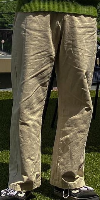

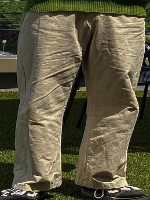

/content/drive/MyDrive/img00/total_img/남자코디_image105_b0_c7.jpg : 0.0


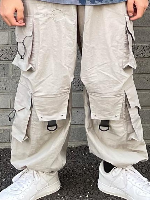

/content/drive/MyDrive/img00/total_img/남자코디_image447_b1_c7.jpg : 0.590674877166748


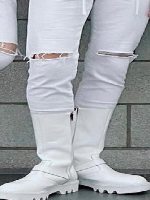

/content/drive/MyDrive/img00/total_img/남성패션_image581_b1_c7.jpg : 0.6196415424346924


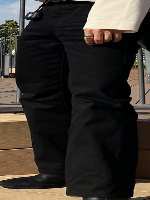

/content/drive/MyDrive/img00/total_img/남자패션_image299_b0_c7.jpg : 0.6198228001594543


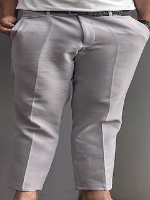

/content/drive/MyDrive/img00/total_img/남자코디_image443_b0_c7.jpg : 0.6454336643218994


In [ ]:
query = '/content/drive/MyDrive/img00/cropped_img2/남자코디_image105_b0_c7.jpg'
result = match_insta(query)
cv2_imshow(cv2.resize(cv2.imread(query), (100,200)))
display(result)

In [ ]:
# match_pair2

def match_pair(fn) :
    fn_dir, fn_name = os.path.split(fn)
    new_name = fn_name.split('_')[0] + '_' + fn_name.split('_')[1] + '_' + fn_name.split('_')[2]  # 0815수정
    print(new_name)
    result = [(v, 1 if fn_name in v else 0) for v in glob.glob(f'{fn_dir}/{new_name}*')]

    i = 0
    while i < len(result):
    if result[i][1] == 1:
          del result[i]
              continue
    i += 1

    return result

target = '/content/drive/MyDrive/img00/new_insta/남자옷_image960_p0_b0_c0.jpg'
match_pair(target)

남자옷_image960_p0


[('/content/drive/MyDrive/img00/new_insta/남자옷_image960_p0_b1_c6.jpg', 0)]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0
/content/drive/MyDrive/img00/new_insta/남자옷_image820_p0_b0_c7.jpg
남자옷_image820_p0


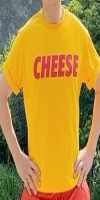

----------
insta pair ('/content/drive/MyDrive/img00/new_insta/남자옷_image820_p0_b1_c8.jpg', 0)


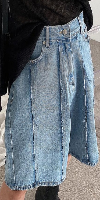

musinsa ('/content/drive/MyDrive/img00/img_mu/1_113.jpg', 1.3271478414535522)


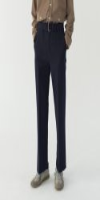

musinsa ('/content/drive/MyDrive/img00/img_mu/1_103.jpg', 1.3284457921981812)


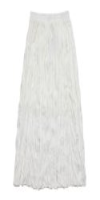

musinsa ('/content/drive/MyDrive/img00/img_mu/1_186.jpg', 1.3395659923553467)


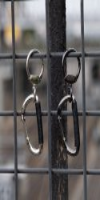

musinsa ('/content/drive/MyDrive/img00/img_mu/1_14.jpg', 1.342211127281189)


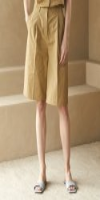

musinsa ('/content/drive/MyDrive/img00/img_mu/1_289.jpg', 1.3469104766845703)


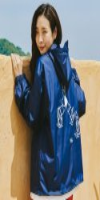

In [ ]:
# 코드 통합

# target : 무신사 옷
# target -> insta search -> insta -> target

target = '/content/drive/MyDrive/img00/new_insta/남자옷_image960_p0_b0_c0.jpg'
def search_pair(target) :
  result = match_insta(target)

  matched = False
  for i in range(len(result)):
    print(i)
    print(result[i][0])
    temp = match_pair(result[i][0])
    if temp != None:
      result = temp
      matched = True
      break
  if not matched:
    result = [] 

  cv2_imshow(cv2.resize(cv2.imread(target), (100,200)))
  print('-'*10)

  for i in range(len(result)) :
    print('insta pair', result[i])
    cv2_imshow(cv2.resize(cv2.imread(result[i][0]), (100,200)))
    temp = match_mu(result[i][0])
    for j in range(len(temp)):
      print('musinsa',temp[j]) 
      cv2_imshow(cv2.resize(cv2.imread(temp[j][0]), (100,200)))

search_pair(target)



0
/content/drive/MyDrive/img00/new_insta/남자옷_image820_p0_b0_c7.jpg
남자옷_image820_p0


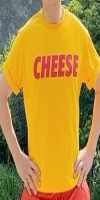

----------
insta pair ('/content/drive/MyDrive/img00/new_insta/남자옷_image820_p0_b1_c8.jpg', 0)


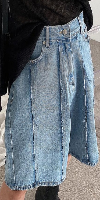

musinsa ('/content/drive/MyDrive/img00/img_mu/1_113.jpg', 1.3271478414535522)


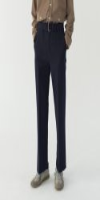

musinsa ('/content/drive/MyDrive/img00/img_mu/1_103.jpg', 1.3284457921981812)


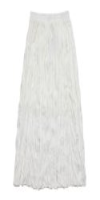

musinsa ('/content/drive/MyDrive/img00/img_mu/1_186.jpg', 1.3395659923553467)


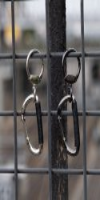

musinsa ('/content/drive/MyDrive/img00/img_mu/1_14.jpg', 1.342211127281189)


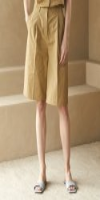

musinsa ('/content/drive/MyDrive/img00/img_mu/1_289.jpg', 1.3469104766845703)


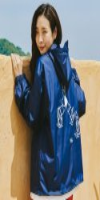

In [ ]:
# 코드 통합

# target : 무신사 옷
# target -> insta search -> insta -> target

target = '/content/drive/MyDrive/img00/new_insta/남자옷_image960_p0_b0_c0.jpg'
def search_pair(target) :
  result = match_insta(target)

  matched = False
  for i in range(len(result)):
    print(i)
    print(result[i][0])
    temp = match_pair(result[i][0])
    if temp != None:
      result = temp
      matched = True
      break
  if not matched:
    result = [] 

  cv2_imshow(cv2.resize(cv2.imread(target), (100,200)))
  print('-'*10)

  for i in range(len(result)) :
    print('insta pair', result[i])
    cv2_imshow(cv2.resize(cv2.imread(result[i][0]), (100,200)))
    temp = match_mu(result[i][0])
    for j in range(len(temp)):
      print('musinsa',temp[j]) 
      cv2_imshow(cv2.resize(cv2.imread(temp[j][0]), (100,200)))

search_pair(target)